# Data visualization

In this Notebook we will look at how to visualize Data.

In [1]:
import os
from datetime import datetime
import numpy as np
from eomaps import Maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datascience.read import Era5, Era5Land, AscatDataH121, Gldas
from datascience.plot import plot_multiple_gpis, plot_ts

%matplotlib widget

ERROR 1: PROJ: proj_create_from_database: Open of /home/oscipal/my_conda/share/proj failed


In contrast to the former Notebooks, this time we will set *read_bulk* to *True*. As already discussed, this has an advantage when reading multiple gpis.

In [2]:
era5 = Era5(read_bulk = True)
ascat = AscatDataH121(read_bulk = True)

In [3]:
lat = 48.198905
lon = 16.367182

You can define a bounding box in which you want to analyze the data. We will need this later on.

In [4]:
lat_min, lat_max = 47, 49
lon_min, lon_max = 15, 17

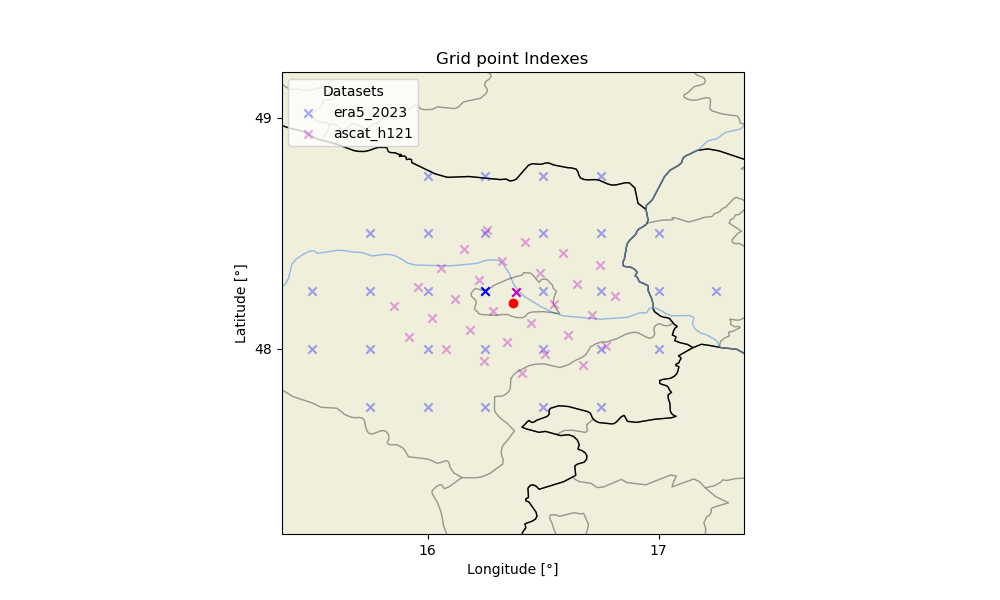

In [5]:
plot_multiple_gpis((lon, lat), era5, ascat, k=30)

With the *obj.grid.get_bbox_grid_points* function, and setting the coordinates of the bounding box, you will get all the gpis in this box as an np.array.

In [6]:
era5_gpis = era5.grid.get_bbox_grid_points(lat_min, lat_max, lon_min, lon_max)
ascat_gpis = ascat.grid.get_bbox_grid_points(lat_min, lat_max, lon_min, lon_max)
ascat_gpis

masked_array(data=[1203175, 1203408, 1203552, 1203785, 1203929, 1204018,
                   1204162, 1204395, 1204539, 1204772, 1205005, 1205149,
                   1205382, 1205526, 1205759, 1205992, 1206136, 1206369,
                   1206513, 1206602, 1206746, 1206979, 1207123, 1207356,
                   1207589, 1207733, 1207966, 1208110, 1208199, 1208343,
                   1208576, 1208720, 1208953, 1209097, 1209186, 1209330,
                   1209563, 1209707, 1209940, 1210173, 1210317, 1210550,
                   1210694, 1210783, 1210927, 1211160, 1211304, 1211537,
                   1211770, 1211914, 1212147, 1212291, 1212524, 1212757,
                   1212901, 1213134, 1213278, 1213367, 1213511, 1213744,
                   1213888, 1214121, 1214354, 1214498, 1214731, 1214875,
                   1214964, 1215108, 1215341, 1215485, 1215718, 1215951,
                   1216095, 1216328, 1216472, 1216705, 1216938, 1217082,
                   1217315, 1217459, 1217548, 12176

You can now load the data into memory, itrerate through the gpis and save the data values and coordinates of each gpi in an np.array. As we set *read_bulk* to *True*, not the whole file has to opened each time, when reading a gpi.

In [7]:
era5_data = []
ascat_data = []

for gpi in era5_gpis:
    era5_data.append(era5.read(gpi)["swvl1"].loc[datetime(2007,1,1,0,0)])

for gpi in ascat_gpis:
    ascat_data.append(ascat.read(gpi)["surface_soil_moisture"].iloc[0])

era5_data = np.array(era5_data)
ascat_data = np.array(ascat_data)

era5_lon, era5_lat = era5.grid.gpi2lonlat(era5_gpis)
ascat_lon, ascat_lat = ascat.grid.gpi2lonlat(ascat_gpis)

You can plot the data with imshow, but to do that, you first need to reshape your data accordingly:

In [8]:
data_reshaped = era5_data.reshape(np.meshgrid(np.unique(era5_lon), np.unique(era5_lat))[0].shape)

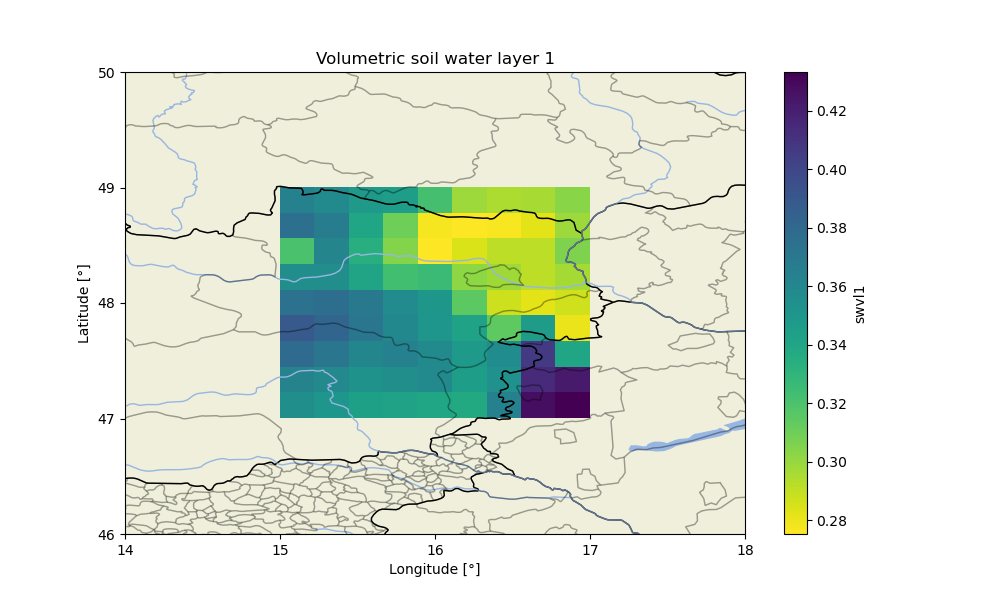

In [9]:
plt.figure(figsize=(10, 6))

# Create a GeoAxes with a PlateCarree projection
ax = plt.axes(projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.RIVERS)
ax.add_feature(cfeature.LAKES)    
ax.add_feature(cfeature.STATES, alpha=0.2)

# Plot the points
plot = ax.imshow(data_reshaped, extent=[lon_min, lon_max, lat_min, lat_max],
                origin='upper', cmap='viridis_r', aspect='auto')

# Create a colorbar
cbar = plt.colorbar(plot, orientation='vertical')
cbar.set_label('swvl1')

# Set ticks and extent
ax.set_xticks(range(-180, 181, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(-90, 91, 1), crs=ccrs.PlateCarree()) 
ax.set_extent([lon_min-1,lon_max+1,lat_min-1,lat_max+1], crs=ccrs.PlateCarree())

# Set title and labels
plt.title('Volumetric soil water layer 1')
plt.xlabel("Longitude [°]")
plt.ylabel("Latitude [°]")
plt.show()

An alternative to imshow is EOmaps. The EOmaps library is a very powerful tool when visualizing data. Find out more about it and play around with the different settings (https://eomaps.readthedocs.io/en/latest/index.html).

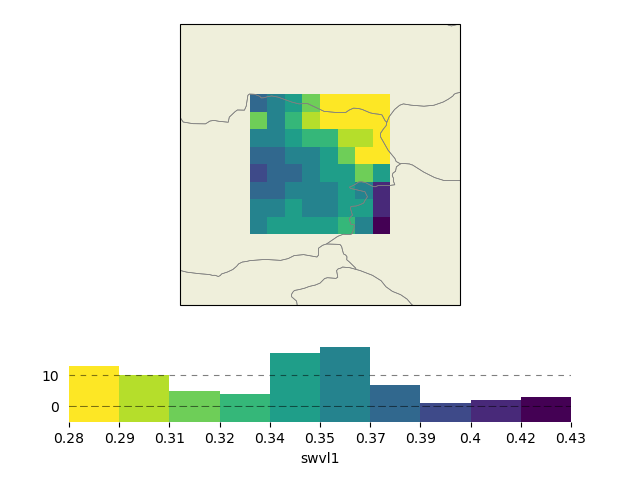

In [10]:
m = Maps()

# Add map features
m.add_feature.preset("ocean", "coastline", "land", "countries")

# Create a new layer and assign data
m_data = m.new_layer()
m_data.set_data(
    data = era5_data,
    x = era5_lon,
    y = era5_lat,
    crs = 4326
    )

# Set extent
m_data.set_extent([lon_min-1,lon_max+1,lat_min-1,lat_max+1])

# Set shape of the data
m_data.set_shape.raster()

# Configure Colorbar
m_data.set_classify.EqualInterval(k=10)
m_data.plot_map(lw=0, cmap="viridis_r")
m_data.add_colorbar(hist_bins="bins", label="swvl1")

m.show()

Beware that you can only plot Era5, Era5Land and GLDAS data as raster data. ASCAT data has to be plotted with geodesic circles:

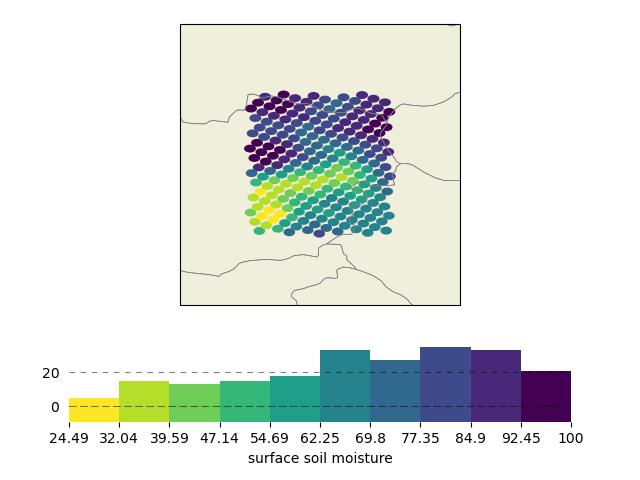

In [11]:
m = Maps()

# Add map features
m.add_feature.preset("ocean", "coastline", "land", "countries")

# Create a new layer and assign data
m_data = m.new_layer()
m_data.set_data(
    data=ascat_data,
    x = ascat_lon,
    y = ascat_lat,
    crs = 4326
    )

# Set extent
m_data.set_extent([lon_min-1,lon_max+1,lat_min-1,lat_max+1])

# Set shape of the data
m_data.set_shape.geod_circles(radius=6250)

# Configure Colorbar
m_data.set_classify.EqualInterval(k=10)
m_data.plot_map(lw=0, cmap="viridis_r")
m_data.add_colorbar(hist_bins="bins", label="surface soil moisture")

m.show()